In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1

from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns_param_v1
from phase_3.strategies.meta.meta_allocator_soft_v1 import build_soft_meta_returns

from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting

from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)


In [13]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../../phase_2/data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df

years = sorted(data["SPY"]["year"].unique())


In [14]:
def sharpe_ratio(x):
    x = np.asarray(x, dtype=float)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(x) / np.nanstd(x)

def max_drawdown(eq):
    eq = np.asarray(eq, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return np.nanmin(dd)


In [15]:
HARD_PARAMS_TIGHT = {
    "trend_mom60_min": 0.0,
    "trend_mom20_min": -0.005,     # tighter than -0.01
    "meanrev_mom20_max": -0.025,   # tighter than -0.02
    "meanrev_dd60_max": -0.03,
    "meanrev_vol20_max": 0.40,
}

In [37]:
def run_portfolio_walkforward(mode: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    mode:
      - "hard": Phase 2 discrete allocator (state-based)
      - "soft": Phase 3 soft allocator (weights-based)

    Returns:
      portfolio_daily: date, portfolio_ret, portfolio_lev, year
      allocator_diag: date, year, asset, (state or weights)
    """
    portfolio_daily_all = []
    allocator_diag_all = []

    for test_year in years:
        asset_daily = {}
        diag_year = []

        for sym, df in data.items():
            train = df[df["year"] < test_year].copy()
            test  = df[df["year"] == test_year].copy()

            if len(train) < 500 or len(test) < 60:
                continue

            trend_out = run_trend_strategy_v1(test, train_df=train)
            meanrev_out = run_meanrev_strategy_v1(test)

            regime = build_regime_features(test)

            if mode == "hard":
                meta = build_meta_raw_returns_param_v1(trend_out, meanrev_out, regime, HARD_PARAMS_TIGHT)
                meta["asset"] = sym
                meta["year"] = test_year
                asset_daily[sym] = meta[["date", "asset", "year", "state", "meta_raw_ret"]]
                diag_year.append(asset_daily[sym])

            elif mode == "soft":
                soft = build_soft_meta_returns(trend_out, meanrev_out, regime, gamma=1.5)
                soft["asset"] = sym
                soft["year"] = test_year
                asset_daily[sym] = soft[["date", "asset", "year", "w_trend", "w_meanrev", "w_cash", "meta_raw_ret"]]
                diag_year.append(asset_daily[sym])

            else:
                raise ValueError(f"Unknown mode: {mode}")

        if len(asset_daily) != len(ASSETS):
            continue

        # Portfolio construction from meta_raw_ret (same for both)
        ret_wide = align_asset_returns(asset_daily)
        w_assets = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)
        port_raw = build_portfolio_raw_returns(ret_wide, w_assets)

        vt = apply_vol_targeting(port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0)

        port = pd.DataFrame({
            "date": port_raw.index,
            "portfolio_raw_ret": port_raw.values,
            "portfolio_lev": vt["lev"].values,
            "portfolio_ret": vt["meta_ret"].values,
            "year": test_year,
        })

        portfolio_daily_all.append(port)
        allocator_diag_all.append(pd.concat(diag_year, ignore_index=True))

    portfolio_daily = pd.concat(portfolio_daily_all).sort_values("date").reset_index(drop=True)
    allocator_diag = pd.concat(allocator_diag_all).sort_values(["date", "asset"]).reset_index(drop=True)

    return portfolio_daily, allocator_diag


In [38]:
portfolio_hard, diag_hard = run_portfolio_walkforward("hard")
portfolio_soft, diag_soft = run_portfolio_walkforward("soft")

portfolio_hard.head(), portfolio_soft.head()


(        date  portfolio_raw_ret  portfolio_lev  portfolio_ret  year
 0 2012-01-03                0.0            0.0            0.0  2012
 1 2012-01-04                0.0            0.0            0.0  2012
 2 2012-01-05                0.0            0.0            0.0  2012
 3 2012-01-06                0.0            0.0            0.0  2012
 4 2012-01-09                0.0            0.0            0.0  2012,
         date  portfolio_raw_ret  portfolio_lev  portfolio_ret  year
 0 2012-01-03                0.0            0.0            0.0  2012
 1 2012-01-04                0.0            0.0            0.0  2012
 2 2012-01-05                0.0            0.0            0.0  2012
 3 2012-01-06                0.0            0.0            0.0  2012
 4 2012-01-09                0.0            0.0            0.0  2012)

In [39]:
print(portfolio_hard["date"].min(), portfolio_hard["date"].max(), len(portfolio_hard))
print(portfolio_soft["date"].min(), portfolio_soft["date"].max(), len(portfolio_soft))


2012-01-03 00:00:00 2025-12-31 00:00:00 3520
2012-01-03 00:00:00 2025-12-31 00:00:00 3520


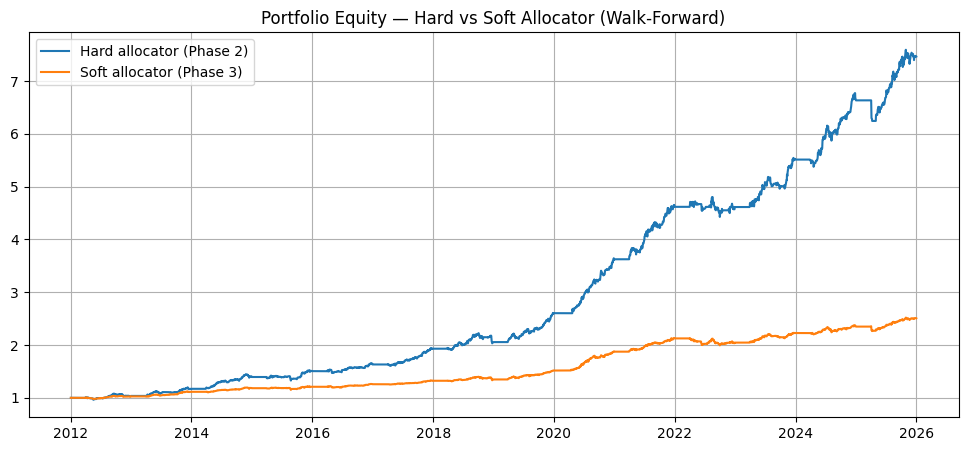

In [40]:
eq_hard = (1 + portfolio_hard["portfolio_ret"]).cumprod()
eq_soft = (1 + portfolio_soft["portfolio_ret"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(portfolio_hard["date"], eq_hard, label="Hard allocator (Phase 2)")
plt.plot(portfolio_soft["date"], eq_soft, label="Soft allocator (Phase 3)")
plt.title("Portfolio Equity — Hard vs Soft Allocator (Walk-Forward)")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
def yearly_summary(portfolio_daily: pd.DataFrame, label: str) -> pd.DataFrame:
    rows = []
    for y, g in portfolio_daily.groupby("year"):
        eq = (1 + g["portfolio_ret"]).cumprod().values
        rows.append({
            "year": y,
            f"sharpe_{label}": sharpe_ratio(g["portfolio_ret"].values),
            f"ret_{label}": eq[-1] - 1.0,
            f"mdd_{label}": max_drawdown(eq),
            f"avgLev_{label}": g["portfolio_lev"].mean(),
        })
    return pd.DataFrame(rows).sort_values("year").reset_index(drop=True)

sum_hard = yearly_summary(portfolio_hard, "hard")
sum_soft = yearly_summary(portfolio_soft, "soft")

compare = sum_hard.merge(sum_soft, on="year", how="inner")
compare["sharpe_diff"] = compare["sharpe_soft"] - compare["sharpe_hard"]
compare["mdd_diff"] = compare["mdd_soft"] - compare["mdd_hard"]  # negative is worse drawdown
compare


,year,sharpe_hard,ret_hard,mdd_hard,avgLev_hard,sharpe_soft,ret_soft,mdd_soft,avgLev_soft,sharpe_diff,mdd_diff
0,2012,0.650502,0.035983,-0.047791,0.920160,0.934687,0.026766,-0.029060,0.924000,0.284185,0.018731
1,2013,2.080086,0.130002,-0.043109,0.917379,2.879315,0.084714,-0.019398,0.924603,0.799229,0.023711
2,2014,2.751054,0.191062,-0.042818,0.924247,2.156820,0.061730,-0.020884,0.924603,-0.594234,0.021934
3,2015,1.056412,0.079806,-0.066821,0.845451,0.625036,0.022585,-0.034206,0.924603,-0.431377,0.032615
4,2016,1.478474,0.083897,-0.041589,0.920772,1.562064,0.040142,-0.022103,0.924603,0.083590,0.019486
5,2017,2.703922,0.182890,-0.023836,0.919217,2.408668,0.051923,-0.006457,0.924303,-0.295254,0.017378
6,2018,0.829372,0.064804,-0.086890,0.887915,0.495402,0.018846,-0.047210,0.924303,-0.333969,0.039680
7,2019,3.183630,0.266496,-0.045717,0.864306,3.180725,0.125200,-0.022640,0.924603,-0.002905,0.023078
8,2020,3.907225,0.392016,-0.025602,0.737269,3.637736,0.235686,-0.023892,0.922237,-0.269489,0.001710
9,2021,2.868887,0.274072,-0.031695,0.851948,3.129313,0.133912,-0.014483,0.924603,0.260426,0.017212


In [42]:
w_year = (
    diag_soft.groupby(["year"])[["w_trend", "w_meanrev", "w_cash"]]
    .mean()
    .reset_index()
)
w_year


,year,w_trend,w_meanrev,w_cash
0,2012,0.167140,0.164748,0.668112
1,2013,0.244459,0.122718,0.632822
2,2014,0.253982,0.126381,0.619638
3,2015,0.178236,0.143522,0.678241
4,2016,0.214968,0.145859,0.639173
5,2017,0.240731,0.129947,0.629322
6,2018,0.198818,0.131665,0.669517
7,2019,0.275563,0.115244,0.609193
8,2020,0.274617,0.072454,0.652929
9,2021,0.265352,0.121840,0.612808


In [43]:
diag_soft = diag_soft.sort_values(["asset", "date"]).reset_index(drop=True)

# day-to-day absolute weight changes per asset
diag_soft["dw_trend"] = diag_soft.groupby("asset")["w_trend"].diff().abs()
diag_soft["dw_meanrev"] = diag_soft.groupby("asset")["w_meanrev"].diff().abs()
diag_soft["dw_cash"] = diag_soft.groupby("asset")["w_cash"].diff().abs()

churn = diag_soft[["dw_trend", "dw_meanrev", "dw_cash"]].mean()
churn


dw_trend      0.025633
dw_meanrev    0.016089
dw_cash       0.021095
dtype: float64